#Assignment 12

* **Step 1; Feature generation:** Try generating and adding other features that seems useful for you, based on your understanding of the problem and what you can observe in the plot. (e.g. holidays, lunchtime, TV time, school time, or additional condition that it should be weekend).
Here you are creating a soup of these features are really needed!

* **Step 2; Feature selection:** Experiment with different combinations of features and find the smallest combination of features that gives you the same (or even higher) accuracy.

**HINT:**

We can start from all features (we have this in DF_features, then I can start removing the ones that I guess they are useless, one by one, retraining the model and then I calculate the new R2 scores).

Then I calculate R2 scores and I see if the R2 scores is reduced or not, if R2 score is not reduced!

 * **Step3; Algorithm selection:** Once you have chosen the smallest set of features, do a  rapid research on available regressions models on sklearn and check if using another algorithm you can improve the accuracy (you can search for promissing  timeseries regression models in sklearn (e.g. extra trees, XGboost, suppoer vetor machines, neural network).

#Reading dataframe, adding lags and time-related features

Importing Google Drive:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Path of the saved "Joined Dataframe":

In [3]:
DF_joined_path = "/content/gdrive/MyDrive/Colab Notebooks/N-EETBS Assignments/Saved Files/Week10_DF_joined"

Importing modules:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

Reading the "Joined Dataframe" as a dataframe:

In [5]:
DF_joined = pd.read_csv(DF_joined_path,index_col=0,parse_dates=[0])
#Shifiting temperature column, because of a time zone issue:
DF_joined["Temperature"] = DF_joined["Temperature"].shift(-1)
DF_joined.head(3)

,Consumption,Temperature,Irradiance
2014-01-01 06:00:00,0.0,37.86,0.000000
2014-01-01 07:00:00,0.0,38.97,0.052800
2014-01-01 08:00:00,0.0,45.85,0.773583


##Lagged column creator

In [6]:
def laggedColumnCreator(DF,columnName,lagStart,lagEnd,lagInterval):
  for i in range(lagStart,lagEnd+1,lagInterval):
    newColumnName = columnName + " -" + str(i) + "h"
    DF[newColumnName] = DF[columnName].shift(i)
    DF.dropna(inplace=True)
  return DF.head(3)

Performing lagged column creator, for consumption, temperature, irradiance:

In [7]:
laggedColumnCreator(DF_joined,"Temperature",1,6,1)

,Consumption,Temperature,Irradiance,Temperature -1h,Temperature -2h,Temperature -3h,Temperature -4h,Temperature -5h,Temperature -6h
2014-01-02 03:00:00,0.0,40.63,0.0,45.27,48.82,51.75,53.09,49.05,53.57
2014-01-02 04:00:00,0.0,38.09,0.0,40.63,45.27,48.82,51.75,53.09,49.05
2014-01-02 05:00:00,0.0,36.82,0.0,38.09,40.63,45.27,48.82,51.75,53.09


In [8]:
laggedColumnCreator(DF_joined,"Consumption",1,24,1)

,Consumption,Temperature,Irradiance,Temperature -1h,Temperature -2h,Temperature -3h,Temperature -4h,Temperature -5h,Temperature -6h,Consumption -1h,Consumption -2h,Consumption -3h,Consumption -4h,Consumption -5h,Consumption -6h,Consumption -7h,Consumption -8h,Consumption -9h,Consumption -10h,Consumption -11h,Consumption -12h,Consumption -13h,Consumption -14h,Consumption -15h,Consumption -16h,Consumption -17h,Consumption -18h,Consumption -19h,Consumption -20h,Consumption -21h,Consumption -22h,Consumption -23h,Consumption -24h
2014-01-14 15:00:00,0.0,74.09,3.329300,74.64,72.88,70.88,68.37,63.42,54.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-14 16:00:00,0.0,70.34,2.124267,74.09,74.64,72.88,70.88,68.37,63.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-14 17:00:00,0.0,64.44,0.451467,70.34,74.09,74.64,72.88,70.88,68.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
laggedColumnCreator(DF_joined,"Irradiance",3,6,1)

,Consumption,Temperature,Irradiance,Temperature -1h,Temperature -2h,Temperature -3h,Temperature -4h,Temperature -5h,Temperature -6h,Consumption -1h,Consumption -2h,Consumption -3h,Consumption -4h,Consumption -5h,Consumption -6h,Consumption -7h,Consumption -8h,Consumption -9h,Consumption -10h,Consumption -11h,Consumption -12h,Consumption -13h,Consumption -14h,Consumption -15h,Consumption -16h,Consumption -17h,Consumption -18h,Consumption -19h,Consumption -20h,Consumption -21h,Consumption -22h,Consumption -23h,Consumption -24h,Irradiance -3h,Irradiance -4h,Irradiance -5h,Irradiance -6h
2014-01-15 09:00:00,0.0,49.51,2.191083,43.73,39.31,39.24,40.81,40.74,42.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0
2014-01-15 10:00:00,0.0,53.34,3.120000,49.51,43.73,39.31,39.24,40.81,40.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078900,0.0000,0.0,0.0
2014-01-15 11:00:00,0.0,57.37,3.865200,53.34,49.51,43.73,39.31,39.24,40.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.862767,0.0789,0.0,0.0


**NOTE:** For irradiance, the reason that w started from 3 hours delay, is the inertia of the system that affect the effectiveness of the outside irradiance regarding the inside atmosphere.

##Time related features creator

In [10]:
def timeRelatedFeaturesCreator(DF):
  DF["Hour"] = DF.index.hour
  DF["Sin(hour)"] = np.sin(DF.index.hour*(2*np.pi/24))
  DF["Cos(hour)"] = np.cos(DF.index.hour*(2*np.pi/24))
  DF["DayOfWeek"] = DF.index.dayofweek

  #Weekend flag
  DF.loc[DF["DayOfWeek"]>4,"WeekendFlag"] = 1
  DF.loc[DF["DayOfWeek"]<5,"WeekendFlag"] = 0

  DF["Month"] = DF.index.month
  DF["WeekOfYear"] = DF.index.week

  #Working hour flag
  DF.loc[:,"WorkingHour"] = 0
  DF.loc[(DF["Hour"]>8) & (DF["Hour"]<19),"WorkingHour"] = 1
  return DF.head(3)

In [11]:
timeRelatedFeaturesCreator(DF_joined)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


,Consumption,Temperature,Irradiance,Temperature -1h,Temperature -2h,Temperature -3h,Temperature -4h,Temperature -5h,Temperature -6h,Consumption -1h,Consumption -2h,Consumption -3h,Consumption -4h,Consumption -5h,Consumption -6h,Consumption -7h,Consumption -8h,Consumption -9h,Consumption -10h,Consumption -11h,Consumption -12h,Consumption -13h,Consumption -14h,Consumption -15h,Consumption -16h,Consumption -17h,Consumption -18h,Consumption -19h,Consumption -20h,Consumption -21h,Consumption -22h,Consumption -23h,Consumption -24h,Irradiance -3h,Irradiance -4h,Irradiance -5h,Irradiance -6h,Hour,Sin(hour),Cos(hour),DayOfWeek,WeekendFlag,Month,WeekOfYear,WorkingHour
2014-01-15 09:00:00,0.0,49.51,2.191083,43.73,39.31,39.24,40.81,40.74,42.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,9,0.707107,-0.707107,2,0.0,1,3,1
2014-01-15 10:00:00,0.0,53.34,3.120000,49.51,43.73,39.31,39.24,40.81,40.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078900,0.0000,0.0,0.0,10,0.500000,-0.866025,2,0.0,1,3,1
2014-01-15 11:00:00,0.0,57.37,3.865200,53.34,49.51,43.73,39.31,39.24,40.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.862767,0.0789,0.0,0.0,11,0.258819,-0.965926,2,0.0,1,3,1


#Implementing machine learning model

Correlation coefficients: How the data in or data frame, correlate to eachother.

In [12]:
DF_joined.corr()

,Consumption,Temperature,Irradiance,Temperature -1h,Temperature -2h,Temperature -3h,Temperature -4h,Temperature -5h,Temperature -6h,Consumption -1h,Consumption -2h,Consumption -3h,Consumption -4h,Consumption -5h,Consumption -6h,Consumption -7h,Consumption -8h,Consumption -9h,Consumption -10h,Consumption -11h,Consumption -12h,Consumption -13h,Consumption -14h,Consumption -15h,Consumption -16h,Consumption -17h,Consumption -18h,Consumption -19h,Consumption -20h,Consumption -21h,Consumption -22h,Consumption -23h,Consumption -24h,Irradiance -3h,Irradiance -4h,Irradiance -5h,Irradiance -6h,Hour,Sin(hour),Cos(hour),DayOfWeek,WeekendFlag,Month,WeekOfYear,WorkingHour
Consumption,1.000000,0.521724,-0.012671,0.568896,0.608693,0.636900,0.650130,0.647824,0.630358,0.907210,0.810686,0.694266,0.568108,0.435503,0.305258,0.184340,0.080421,-0.003920,-0.067552,-0.108624,-0.124250,-0.108836,-0.068509,-0.005183,0.079421,0.180967,0.299802,0.424185,0.550683,0.667829,0.769738,0.849304,0.899850,0.364558,0.467597,0.533907,0.555446,0.361309,-0.438630,0.212352,-0.014287,-0.005789,0.128654,0.139571,-0.053224
Temperature,0.521724,1.000000,0.417455,0.990929,0.968220,0.935054,0.894855,0.850855,0.805923,0.471064,0.419971,0.371974,0.329938,0.295097,0.269433,0.253663,0.247429,0.252234,0.269514,0.298701,0.338184,0.385092,0.436106,0.488208,0.535684,0.575150,0.603971,0.619285,0.620342,0.606427,0.578037,0.538803,0.493154,0.423460,0.372839,0.306134,0.229971,0.203656,-0.264911,-0.245972,0.040879,0.037785,0.162030,0.191452,0.312651
Irradiance,-0.012671,0.417455,1.000000,0.352507,0.265570,0.167266,0.067117,-0.026136,-0.105374,-0.119438,-0.204998,-0.267436,-0.308658,-0.328658,-0.328180,-0.308976,-0.274321,-0.224486,-0.157576,-0.072379,0.030154,0.146167,0.261050,0.367356,0.451607,0.509564,0.531555,0.509566,0.442563,0.343029,0.219730,0.091966,-0.025238,0.560717,0.329463,0.103857,-0.094929,0.167518,-0.237089,-0.740872,-0.028956,-0.031144,-0.034498,-0.027031,0.766392
Temperature -1h,0.568896,0.990929,0.352507,1.000000,0.990924,0.968214,0.935048,0.894849,0.850846,0.521737,0.471074,0.419978,0.371978,0.329938,0.295096,0.269430,0.253659,0.247424,0.252230,0.269511,0.298699,0.338185,0.385097,0.436114,0.488219,0.535698,0.575167,0.603990,0.619304,0.620361,0.606446,0.578054,0.538817,0.450910,0.423462,0.372837,0.306128,0.235819,-0.319935,-0.168644,0.039554,0.037627,0.162718,0.192227,0.264076
Temperature -2h,0.608693,0.968220,0.265570,0.990924,1.000000,0.990925,0.968214,0.935049,0.894846,0.568893,0.521735,0.471072,0.419976,0.371977,0.329938,0.295096,0.269430,0.253660,0.247425,0.252230,0.269512,0.298699,0.338185,0.385096,0.436113,0.488217,0.535696,0.575164,0.603987,0.619301,0.620358,0.606443,0.578051,0.450116,0.450909,0.423461,0.372837,0.257656,-0.352928,-0.079602,0.038365,0.037526,0.163477,0.193088,0.189602
Temperature -3h,0.636900,0.935054,0.167266,0.968214,0.990925,1.000000,0.990924,0.968215,0.935047,0.608689,0.568890,0.521732,0.471070,0.419975,0.371976,0.329938,0.295096,0.269431,0.253660,0.247425,0.252231,0.269512,0.298699,0.338185,0.385095,0.436111,0.488215,0.535693,0.575161,0.603983,0.619297,0.620354,0.606439,0.417344,0.450116,0.450908,0.423461,0.267438,-0.361696,0.014971,0.037393,0.037490,0.164281,0.193961,0.102968
Temperature -4h,0.650130,0.894855,0.067117,0.935048,0.968214,0.990924,1.000000,0.990924,0.968214,0.636902,0.608691,0.568892,0.521734,0.471071,0.419976,0.371977,0.329938,0.295096,0.269430,0.253660,0.247425,0.252231,0.269512,0.298699,0.338185,0.385095,0.436112,0.488216,0.535695,0.575162,0.603985,0.619299,0.620356,0.352374,0.417344,0.450116,0.450908,0.262440,-0.345663,0.108590,0.036727,0.037571,0.165108,0.194824,0.013943
Temperature -5h,0.647824,0.850855,-0.026136,0.894849,0.935049,0.968215,0.990924,1.000000,0.990924,0.650127,0.636899,0.608688,0.568889,0.521732,0.471069,0.419975,0.371976,0.329938,0.295096,0.269431,0.253660,0.247426,0.252231,0.269512,0.298700,0.338185,0.385094,0.436111,0.488214,0.535692,0.575159,0.603982,0.619296,0.265436,0.352374,0.417344,0.450115,0.23781

##1-Defining target

Choosing the moments of the year that we may use air conditioning system (from March to the end of September is a relevant period). So, we are narrowing our dataframe from a year, to 6 month. To recap, we are performing the following stages on our dataframe:

* i. Narrowing the time to a specified period.
* ii. Extracting the target (consumption) as a data frame.
* iii. Extracting the variables/features (all, but not consumption) as a data frame.

In [14]:
DF_joined = DF_joined.loc["2014-03-01":"2014-09-30"]

DF_target = DF_joined[["Consumption"]]
DF_features = DF_joined.drop("Consumption",axis=1)

In fact, as we are analyzing the "consumption", so we make it as our target and other variables in our data frame, as the features which we want to analyze their effect on the consumption.

In [15]:
DF_target.head(3)

,Consumption
2014-03-01 00:00:00,0.0
2014-03-01 01:00:00,0.0
2014-03-01 02:00:00,0.0


In [16]:
DF_features.head(3)

,Temperature,Irradiance,Temperature -1h,Temperature -2h,Temperature -3h,Temperature -4h,Temperature -5h,Temperature -6h,Consumption -1h,Consumption -2h,Consumption -3h,Consumption -4h,Consumption -5h,Consumption -6h,Consumption -7h,Consumption -8h,Consumption -9h,Consumption -10h,Consumption -11h,Consumption -12h,Consumption -13h,Consumption -14h,Consumption -15h,Consumption -16h,Consumption -17h,Consumption -18h,Consumption -19h,Consumption -20h,Consumption -21h,Consumption -22h,Consumption -23h,Consumption -24h,Irradiance -3h,Irradiance -4h,Irradiance -5h,Irradiance -6h,Hour,Sin(hour),Cos(hour),DayOfWeek,WeekendFlag,Month,WeekOfYear,WorkingHour
2014-03-01 00:00:00,55.80,0.0,57.88,58.61,61.53,61.77,65.87,68.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060583,0,0.000000,1.000000,5,1.0,3,9,0
2014-03-01 01:00:00,54.14,0.0,55.80,57.88,58.61,61.53,61.77,65.87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,0.258819,0.965926,5,1.0,3,9,0
2014-03-01 02:00:00,52.78,0.0,54.14,55.80,57.88,58.61,61.53,61.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2,0.500000,0.866025,5,1.0,3,9,0


For the machine learning, we need to compare the data produced by our model, to a reference. Hence, we divide our set of data into two basket:

* **Train:** Using these set of data to train our model. In fact, with machine learning, we are learn the behaviour of our objective (objective function) with respect to a set of features (variables).
* **Test:** Using these set of data to compare the model output, with a real data, *FOR THE SAME INPUT (FEATURES) VALUES.*

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(DF_features,DF_target,test_size=0.2,random_state=41234) #So, 0.8 of data are used to train our model.

In [19]:
X_test.describe()

,Temperature,Irradiance,Temperature -1h,Temperature -2h,Temperature -3h,Temperature -4h,Temperature -5h,Temperature -6h,Consumption -1h,Consumption -2h,Consumption -3h,Consumption -4h,Consumption -5h,Consumption -6h,Consumption -7h,Consumption -8h,Consumption -9h,Consumption -10h,Consumption -11h,Consumption -12h,Consumption -13h,Consumption -14h,Consumption -15h,Consumption -16h,Consumption -17h,Consumption -18h,Consumption -19h,Consumption -20h,Consumption -21h,Consumption -22h,Consumption -23h,Consumption -24h,Irradiance -3h,Irradiance -4h,Irradiance -5h,Irradiance -6h,Hour,Sin(hour),Cos(hour),DayOfWeek,WeekendFlag,Month,WeekOfYear,WorkingHour
count,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1.026000e+03,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,74.650565,1.079127,74.620858,74.595068,74.617115,74.616413,74.588596,74.542476,496.986826,498.872368,493.595760,494.644916,495.597206,492.470273,497.214555,481.010071,482.929288,487.746118,492.091553,500.465058,507.808203,509.763726,517.748067,515.592544,515.388255,511.144396,497.728720,510.311306,513.855003,507.655702,499.649496,515.825162,1.097127,1.093740,1.106376,1.099671,11.709552,-0.019423,-1.451264e-02,2.944444,0.276803,5.907407,24.081871,0.428850
std,12.778735,1.460083,12.837607,12.853796,12.873196,12.925847,12.992935,12.992747,751.663791,749.958746,744.453264,738.574436,728.530120,730.150038,741.953415,724.746905,729.829586,737.259429,747.421715,762.150545,757.501897,756.547034,776.521167,762.482050,750.994611,736.063798,732.463342,749.220682,765.542868,762.539189,750.755898,767.748367,1.457502,1.447749,1.457660,1.463113,6.855259,0.715012,6.993890e-01,1.999471,0.447637,1.968583,8.700610,0.495153
min,23.760000,0.000000,22.920000,23.240000,22.920000,23.240000,23.370000,24.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000e+00,0.000000,0.000000,3.000000,9.000000,0.000000
25%,67.785000,0.000000,67.842500,67.850000,67.710000,67.455000,66.955000,67.215000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,-0.707107,-7.071068e-01,1.000000,0.000000,4.000000,17.000000,0.000000
50%,76.015000,0.150683,76.155000,75.935000,76.000000,76.230000,76.060000,76.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166092,0.185033,0.175692,0.158708,12.000000,0.000000,-1.836970e-16,3.000000,0.000000,6.000000,24.000000,0.000000
75%,83.307500,1.930408,83.200000,83.235000,83.520000,83.452500,83.482500,83.385000,791.325000,814.091667,771.516667,799.983333,823.258333,812.770833,791.783333,748.762500,737.050000,764.950000,781.125000,729.408333,801.725000,830.129167,800.245833,850.666667,845.658333,846.370833,814.370833,827.970833,804.854167,778.641667,796.283333,835.166667,2.178808,2.002517,2.230163,2.063825,18.000000,0.707107,7.071068e-01,5.000000,1.000000,8.000000,31.000000,1.000000
max,100.230000,5.014383,100.250000,99.720000,100.100000,100.280000,100.540000,100.540000,2776.350000,2793.466667,2835.816667,2841.000000,2835.816667,2818.583333,2794.400000,2793.466667,

In [20]:
X_train.describe()

,Temperature,Irradiance,Temperature -1h,Temperature -2h,Temperature -3h,Temperature -4h,Temperature -5h,Temperature -6h,Consumption -1h,Consumption -2h,Consumption -3h,Consumption -4h,Consumption -5h,Consumption -6h,Consumption -7h,Consumption -8h,Consumption -9h,Consumption -10h,Consumption -11h,Consumption -12h,Consumption -13h,Consumption -14h,Consumption -15h,Consumption -16h,Consumption -17h,Consumption -18h,Consumption -19h,Consumption -20h,Consumption -21h,Consumption -22h,Consumption -23h,Consumption -24h,Irradiance -3h,Irradiance -4h,Irradiance -5h,Irradiance -6h,Hour,Sin(hour),Cos(hour),DayOfWeek,WeekendFlag,Month,WeekOfYear,WorkingHour
count,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4.104000e+03,4.104000e+03,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000
mean,75.353765,1.084325,75.356708,75.358531,75.348789,75.344432,75.347395,75.354808,528.957464,528.166776,529.163942,528.463178,527.720821,528.037301,526.494782,530.064453,529.365660,528.077307,526.990948,524.897571,523.061785,522.572904,520.576819,521.115700,521.166772,522.227737,525.581656,522.393734,521.419022,522.798071,524.599858,520.415396,1.079825,1.080672,1.077513,1.079051,11.437865,5.474517e-03,2.504333e-03,3.014133,0.292885,6.021686,24.624756,0.414230
std,12.915844,1.465994,12.903714,12.901915,12.899089,12.887423,12.870555,12.869323,765.583901,765.967568,767.196867,768.415179,770.485397,769.809884,766.940566,770.546747,769.400014,767.735476,765.330208,761.774289,762.979509,763.225142,758.217653,761.765791,764.610919,768.217842,768.992137,765.054773,761.058481,761.826811,764.722128,760.617628,1.466617,1.469037,1.466541,1.465282,6.934184,7.053208e-01,7.090346e-01,2.015126,0.455142,2.004326,8.854142,0.492649
min,22.920000,0.000000,23.240000,22.920000,23.240000,22.920000,22.920000,22.920000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,0.000000,0.000000,3.000000,9.000000,0.000000
25%,68.810000,0.000000,68.810000,68.880000,68.897500,68.907500,68.932500,69.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,-7.071068e-01,-7.071068e-01,1.000000,0.000000,4.000000,17.000000,0.000000
50%,76.805000,0.108883,76.785000,76.845000,76.770000,76.760000,76.735000,76.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105642,0.099625,0.094417,0.102433,11.000000,1.224647e-16,6.123234e-17,3.000000,0.000000,6.000000,25.000000,0.000000
75%,84.105000,2.180758,84.150000,84.122500,84.132500,84.092500,84.142500,84.082500,859.841667,847.379167,860.200000,847.379167,845.512500,845.395833,849.341667,867.220833,862.470833,850.166667,857.016667,861.175000,845.395833,840.883333,839.616667,837.145833,837.145833,837.145833,845.512500,841.320833,845.395833,845.875000,849.554167,840.420833,2.124621,2.147838,2.074283,2.150017,17.000000,7.071068e-01,7.071068e-01,5.000000,1.000000,8.000000,32.000000,1.000000
max,101.050000,5.099667,101.050000,101.050000,101.050000,101.050000,101.050000,101.050000,2841.000000,2841.000000,2841.000000,2805.566667,2841.000000,2841.000000,2

In [21]:
y_test.describe()

,Consumption
count,1026.000000
mean,498.709519
std,755.851022
min,0.000000
25%,0.000000
50%,0.000000
75%,799.762500
max,2747.166667


In [22]:
y_train.describe()

,Consumption
count,4104.000000
mean,528.878476
std,764.659503
min,0.000000
25%,0.000000
50%,0.000000
75%,859.066667
max,2841.000000


##2-Defining algorithm: Linear regression

In [ ]:
from sklearn import linear_model
linearReg = linear_model.LinearRegression()

Training our model "target" with the "algorithm":

**NOTE:** So, the model is trained to calculate "consumption" based on ALL the variables that we defined in DF_features. These variables however, could be NOT relevant to the target i the training process. We must recognize these EXTRA values based on detail analysis of the model.

**NOTE:** When we train our model, we are using the dedicated "train" variables (0.8 of our data in our model). The separated "test" data are further using in order to "check" the accuracy of the trained model (comparing the real "test" data, to corrosponding "predicted" values, for the "same X_test").

In [ ]:
linearReg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

##3-Check the trained model

Now, using the trained model, to predict the "y" values of "X_test" and compare it to corrosponding real values of "Y_test":

In [ ]:
linearRegPredicted = linearReg.predict(X_test)
DF_linearRegPredicted = pd.DataFrame(linearRegPredicted,index=y_test.index,columns=["Consumption_linearRegPredicted"])
DF_linearRegPredicted.head(3)

,Consumption_linearRegPredicted
2014-03-10 22:00:00,-86.210324
2014-03-15 06:00:00,44.431003
2014-05-11 22:00:00,1523.911612


The indiced are not in order, as the "test" data are defined randomly.

Now, we want to join the real consumption values for the "test" data and compare them to the predicted values:

In [ ]:
DF_linearRegPredicted = DF_linearRegPredicted.join(y_test)
DF_linearRegPredicted.head(10)

,Consumption_linearRegPredicted,Consumption
2014-03-10 22:00:00,-86.210324,0.000000
2014-03-15 06:00:00,44.431003,0.000000
2014-05-11 22:00:00,1523.911612,1230.183333
2014-04-10 19:00:00,220.738732,0.000000
2014-06-28 03:00:00,192.717812,464.400000
2014-06-18 04:00:00,235.939479,232.233333
2014-03-12 13:00:00,-23.940169,0.000000
2014-03-12 20:00:00,106.572434,0.000000
2014-08-02 01:00:00,507.226275,259.200000
2014-07-02 17:00:00,2153.646142,2605.866667


Plotting the two columns for the month of **AUGUST**:

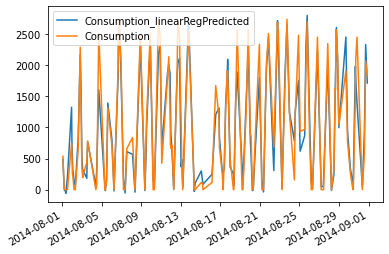

In [ ]:
DF_linearRegPredicted_august = DF_linearRegPredicted.loc["2014-08-01":"2014-08-31"]
DF_linearRegPredicted_august.plot()

We can see that or "trained machine" are predicting acceptably the "test" data (comparing the values of trained model to the real consumption values of the test data, shows a few differences at the first look).

To discuss about the variation of the values, we can use the accurate numerical errors: